# Bias Mitigation in Automated Loan Eligibility Process
**@authors: Chiara Angileri, Niccolò Marzi, Shola Oshodi** 

The dataset can be found in this link: https://www.kaggle.com/datasets/burak3ergun/loan-data-set/code?datasetId=74581

In [107]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression


## 1. Dataset inspection and preparation

### 1.1 Inspection

In [108]:
#importing the dataset

df = pd.read_csv('loan_data_set.csv')
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


**Dataset Description:**

| Variable | Description | 
|------|------|
| Loan_ID | Unique Loan ID | 
| Gender | Male/ Female | 
| Married | Applicant married (Y/N) | 
| Dependents | Number of dependents | 
| Education | Applicant Education (Graduate/ Under Graduate) | 
| Self_Employed | Self employed (Y/N) | 
| ApplicantIncome | Applicant income | 
| CoapplicantIncome | Coapplicant income | 
| LoanAmount | Loan amount in thousands | 
| Loan_Amount_Term | Term of loan in months | 
| Credit_History | credit history meets guidelines | 
| Property_Area | Urban/ Semi Urban/ Rural | 
| Loan_Status | Loan approved (Y/N) | 


There are 615 observations in this dataset


We will now investigate the dataset data distribution

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_column_distributions(data, palette='husl', type='discrete'):
    num_columns = data.shape[1]
    num_rows = (num_columns + 2) // 3  # Calculate the number of rows needed for the subplots grid
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 4 * num_rows))  # Create subplots grid
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, column in enumerate(data.columns):
        ax = axes[i]
        if type == 'discrete':
            sns.countplot(x=data[column], palette=palette, ax=ax)
            ax.set_xlabel('Categories')
            ax.set_xlabel('Distribution of ' + column)
            ax.set_ylabel('Count')
            ax.tick_params(axis='x', rotation=45)
            # Add counts above the bars
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center', color='black', xytext=(0, 5),
                            textcoords='offset points')
        else:
            sns.boxplot(x=data[column], color=palette[i], ax=ax, orient='V')
            ax.set_ylabel('Values')
            ax.set_xlabel('Distribution of ' + column)
            # Add gridlines
            ax.yaxis.grid(True)
            # Remove the top and right spines
            sns.despine(ax=ax)
            
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'data' is your DataFrame
# plot_column_distributions(data)


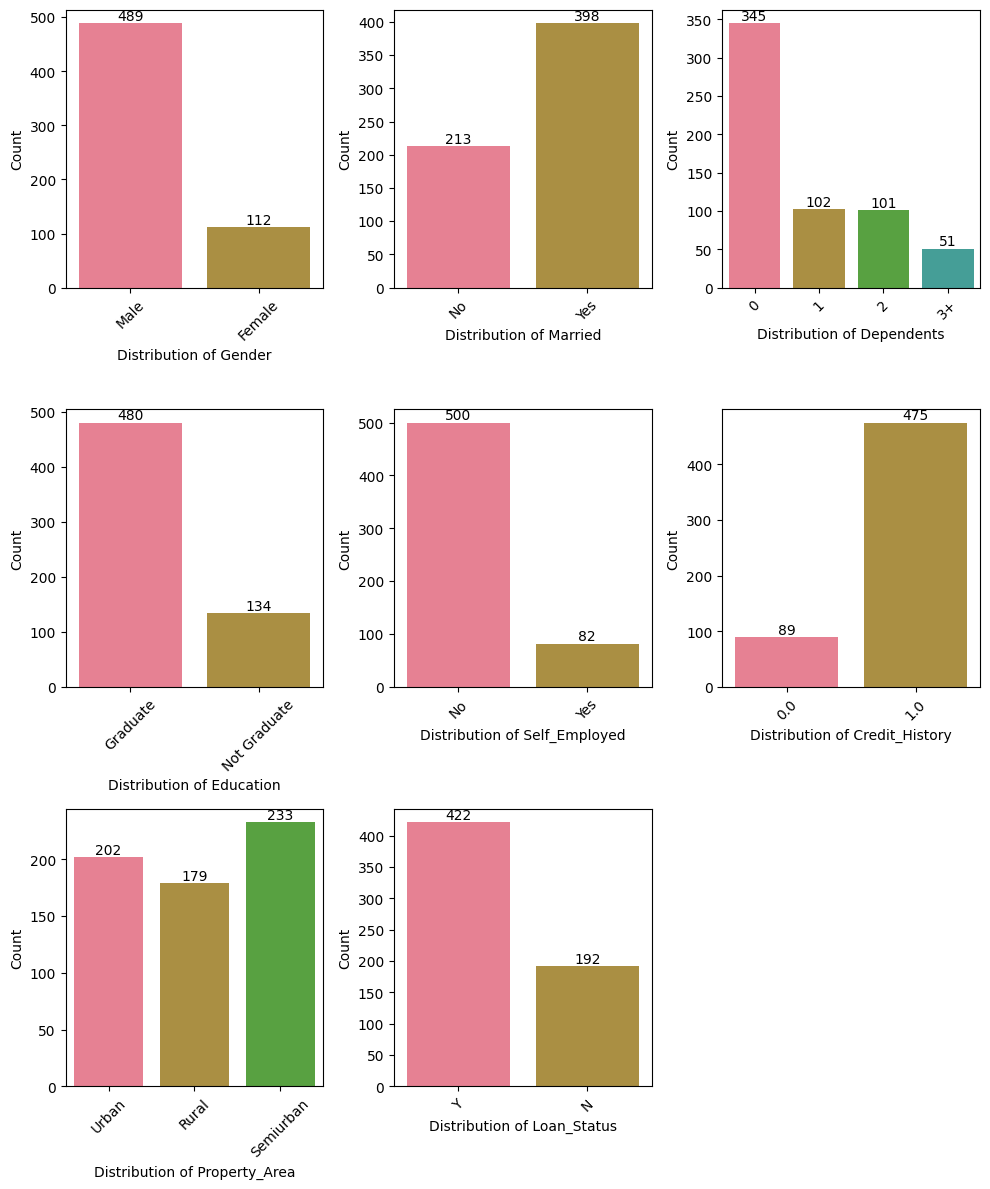

In [110]:
palette = sns.color_palette("husl")
#convert float64 to object
df['Credit_History'] = df['Credit_History'].astype('object')
discrete_columns = df.select_dtypes(include=['object']).columns.tolist()[1:]


plot_column_distributions(df[discrete_columns], palette)


- Observing the distributions of the variables, one can notice an imbalance regarding the representation of men and women in the dataset, particularly with men accounting for  79,5% of cases.

- The majority of the subjects examined are married, have a high school diploma, do not have dependents, and are not self-employed.

- Their residential area ownership appears balanced, with a slight predominance of semi-urban areas.

- Regarding the target variable in most of the cases the loan status is positive (68%) as also their credit history 

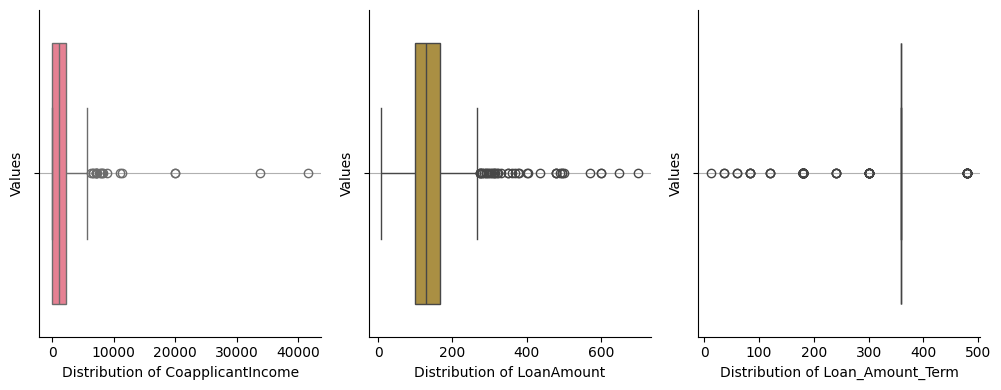

In [111]:
continuos_columns = df.select_dtypes(include=['float64']).columns.tolist()
plot_column_distributions(df[continuos_columns], palette, "continue")


- Typically, applicants have an average income lower than 10000, but there are cases of higher income, up to 40000.
- The loan amount typically falls within the range of 150000 to 250000, with some loans reaching up to 400000, although higher values are rare.
- The loan term commonly spans around 350 months.

## 1.2 Data Preparation

Since each record has a different **Loan_ID** it can be dropped

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    object 
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 62.5+ KB


In [113]:
# Drop irrelevant columns
#df.drop(columns=['Loan_ID', 'LoanAmount', 'Loan_Amount_Term'], inplace=True)
df.drop(columns=['Loan_ID'], inplace=True)

# TODO: NICO: Da decidere se i due 'Loan amount' ci possono essere utili invece di dropparle, si potrebbero tenere solo quelle in cui non sono NaN.
# SHO: Secondo me possono essere utili, anche la lunghezza del mutuo potrebbe essere utile. Ci sono pochi NaN quindi quelle poche righe metterei la media 

How many missing values are there?

In [114]:
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Since Loan Amount and Loan Term aren't Nan frequently we decided to fill the Nan values with their means when they occur

In [115]:
df['LoanAmount'].fillna(int(df['LoanAmount'].mean()), inplace=True)
df['Loan_Amount_Term'].fillna(int(df['Loan_Amount_Term'].mean()), inplace=True)

For simplicity, we will drop rows with missing values in **Gender** and **Married**, 

In [116]:
df = df[(~df['Gender'].isnull()) & (~df['Married'].isnull())]

for the others we treat them as a separate category.

In [117]:
df['Dependents'] = df['Dependents'].map({'0': '0',
                                         '1': '1',
                                         '2': '2',
                                         '3+': '3'})

fill_values = {'Self_Employed': 'NaN', 'Dependents': 'NaN', 'Credit_History': -1}
df.fillna(value=fill_values, inplace=True)

In [118]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Now we need to encode the categorical columns

In [119]:
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 
                    'Credit_History', 'Property_Area', 'Dependents', 'Loan_Status']
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le


For non-binary columns we make the one-hot-encode of them

In [120]:
non_binary_cols = ['Self_Employed', 'Credit_History', 'Property_Area', 'Dependents']

encoded_features = []
ohe = OneHotEncoder()

for feature in non_binary_cols:
    encoded_feat = OneHotEncoder(drop='first').fit_transform(df[feature].values.reshape(-1, 1)).toarray()
    n = df[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(0, n-1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df.index
    encoded_features.append(encoded_df)
    
df = pd.concat([df.drop(columns=non_binary_cols), *encoded_features], axis=1)

In [121]:
df

,Gender,Married,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Self_Employed_0,Self_Employed_1,Credit_History_0,Credit_History_1,Property_Area_0,Property_Area_1,Dependents_0,Dependents_1,Dependents_2,Dependents_3
0,1,0,0,5849,0.0,146.0,360.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,0,4583,1508.0,128.0,360.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1,0,3000,0.0,66.0,360.0,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,1,2583,2358.0,120.0,360.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,0,0,6000,0.0,141.0,360.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,2900,0.0,71.0,360.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
610,1,1,0,4106,0.0,40.0,180.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
611,1,1,0,8072,240.0,253.0,360.0,1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
612,1,1,0,7583,0.0,187.0,360.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


## 1.3 Dataset Split

In [122]:
# Splitting the dataset into the Training set and Test set
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

## 2. Baseline Model 

In order to effectively manage any existing biases, we decide to use a simple logistic regression model as a baseline and then utilize the Fairlearn package to assess its fairness.


In [123]:
baseline = LogisticRegression(solver='liblinear', fit_intercept=True)
baseline.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [124]:
print('Train accuracy:', baseline.score(train_X, train_y))
print('Test accuracy:', baseline.score(test_X, test_y))


Train accuracy: 0.801255230125523
Test accuracy: 0.8083333333333333


## 3. Fearness Evaluation

In [167]:
import fairlearn.metrics as flm
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

The use of Fairlearn allows us to verify if there are discriminations that affect a particular group of people by comparing the data regarding these groups with those concerning the response of the population.

Therefore, it is necessary to define the type of grouping that we want to perform on the population. In our case, we will begin by investigating gender discriminations and then subsequently explore further biases.

To evaluate the model's performance, we have decided to use ROC curves and apply the following fairness metrics:
- Demographic Parity
- Equalized Odds

In [173]:
def score_per_group(metric_func,y_true, y_pred, sensitive_features):
    unique_groups = sensitive_features.unique()
    scores = {}
    for group in unique_groups:
        idx = (sensitive_features == group)
        y_true_group = y_true[idx]
        y_pred_group = y_pred[idx]
        scores[group] =metric_func(y_true_group, y_pred_group)
    return scores

In [194]:
def display_scores_per_groups(auc_scores, le, title):
    df = pd.DataFrame(auc_scores, index=[title]).T
    df.index = le.inverse_transform(df.index)

    display(df)


In [175]:
sensitive_features = test_X["Gender"]
pred_y = baseline.predict(test_X)

In [184]:
roc_per_group = score_per_group(roc_auc_score,test_y, pred_y, sensitive_features)
acc_per_group = score_per_group(balanced_accuracy_score,test_y, pred_y, sensitive_features)
err_per_group = {group: 1 - acc_score for group, acc_score in acc_per_group.items()}


In [185]:
fairlearn_metrics = {}
pred_y = baseline.predict(test_X)
fairlearn_metrics["ROC AUC"] = roc_auc_score(test_y, pred_y)
fairlearn_metrics["ROC AUC Difference"] = max(err_per_group.values()) - min(err_per_group.values())
fairlearn_metrics["Equalize Odds Difference"] = flm.equalized_odds_difference(test_y, pred_y, sensitive_features=sensitive_features)
fairlearn_metrics["Balanced Error Rate"] = 1-balanced_accuracy_score(test_y, pred_y)
fairlearn_metrics["Balanced Error Rate Difference"] = max(err_per_group.values()) - min(err_per_group.values())
fairlearn_metrics["Selection Rate"] = flm.selection_rate(test_y, pred_y)
fairlearn_metrics["Demographic Parity Difference"] = flm.demographic_parity_difference(test_y, baseline.predict(test_X), sensitive_features=sensitive_features)
fairlearn_metrics["Demographic Parity Ratio"] = flm.demographic_parity_ratio(test_y, baseline.predict(test_X), sensitive_features=sensitive_features)

- the **Demographic Parity** metric requires that the proportion of each subgroup within a protected feature (such as gender) receiving the positive outcome should be equal across all subgroups.


- the **Equalized Odds** metric demands that the model correctly identifies positive outcomes at equal rates across groups. Additionally, it requires the model to misclassify positive outcomes at equal rates across groups, thus creating the same proportion of False Positives across all groups.

In [195]:
display(pd.DataFrame(fairlearn_metrics, index=["Value"]).T)
display_scores_per_groups(roc_per_group, encoders["Gender"], "ROC AUC")
display_scores_per_groups(err_per_group, encoders["Gender"], "Balanced Error Rate")

,Value
ROC AUC,0.706224
ROC AUC Difference,0.051339
Equalize Odds Difference,0.071429
Balanced Error Rate,0.293776
Balanced Error Rate Difference,0.051339
Selection Rate,0.825000
Demographic Parity Difference,0.140523
Demographic Parity Ratio,0.851211


,ROC AUC
Male,0.698661
Female,0.750000


,Balanced Error Rate
Male,0.301339
Female,0.250000
